In [8]:
import numpy as np

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

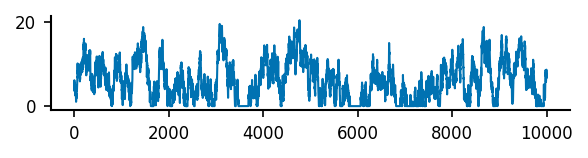

In [22]:
mean, sigma, tau = 5, 5, 10
tstop = 1000
dt = 0.1
OU = np.clip(OrnsteinUhlenbeck_Process(mean, sigma, tau, dt, tstop), 0, np.inf)

fig, ax = pt.figure(figsize=(2,1))
ax.plot(OU)

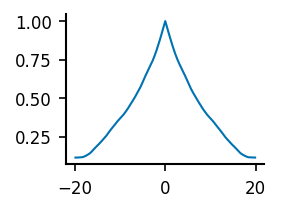

In [23]:
CCF, ts = crosscorrel(OU, OU, 20, dt)
plt.plot(ts, CCF)